In [1]:
import numpy as np
import pyvista as pv
from matplotlib import pyplot as plt
import pandas as pd


In [2]:
df = pd.read_csv('../data/FEM/random/random_params.csv')
df


,r0,r1,h0,h1,bevel,pocket_r,neck_x,neck_r,neck_h,neck_dh
0,0.002468,0.002877,0.000995,0.002249,0.000107,0.000825,0.001706,0.001199,0.002447,0.000042
1,0.002360,0.002947,0.000981,0.002108,0.000126,0.000825,0.001710,0.001199,0.002460,0.000060
2,0.002180,0.002894,0.000988,0.002051,0.000197,0.000825,0.001700,0.001199,0.002501,0.000112
3,0.002360,0.002875,0.000871,0.001968,0.000097,0.000825,0.001708,0.001208,0.002437,0.000089
4,0.002280,0.002755,0.000816,0.002230,0.000087,0.000825,0.001692,0.001205,0.002396,0.000032
...,...,...,...,...,...,...,...,...,...,...
95,0.002287,0.002866,0.001023,0.002073,0.000126,0.000825,0.001706,0.001195,0.002528,0.000072
96,0.002326,0.002913,0.000950,0.002155,0.000108,0.000825,0.001700,0.001210,0.002473,0.000072
97,0.002306,0.002915,0.000945,0.002193,0.000163,0.000825,0.001697,0.001194,0.002445,0.000047
98,0.002374,0.002840,0.000906,0.002171,0.000079,0.000825,0.001697,0.001205,0.002496,0.000062


In [3]:
read_mesh = lambda i: pv.read(f'../data/FEM/random/FEM2_{i}.vtu')

mesh0 = read_mesh(0)
mises0 = mesh0.point_data['von_mises_stress']

max_index = np.argmax(mises0)
max_index


4595

In [4]:
mises_array = np.zeros(100)

for i in range(100):
    mesh = read_mesh(i)
    mises = mesh.point_data['von_mises_stress']
    mises_array[i] = mises[max_index]


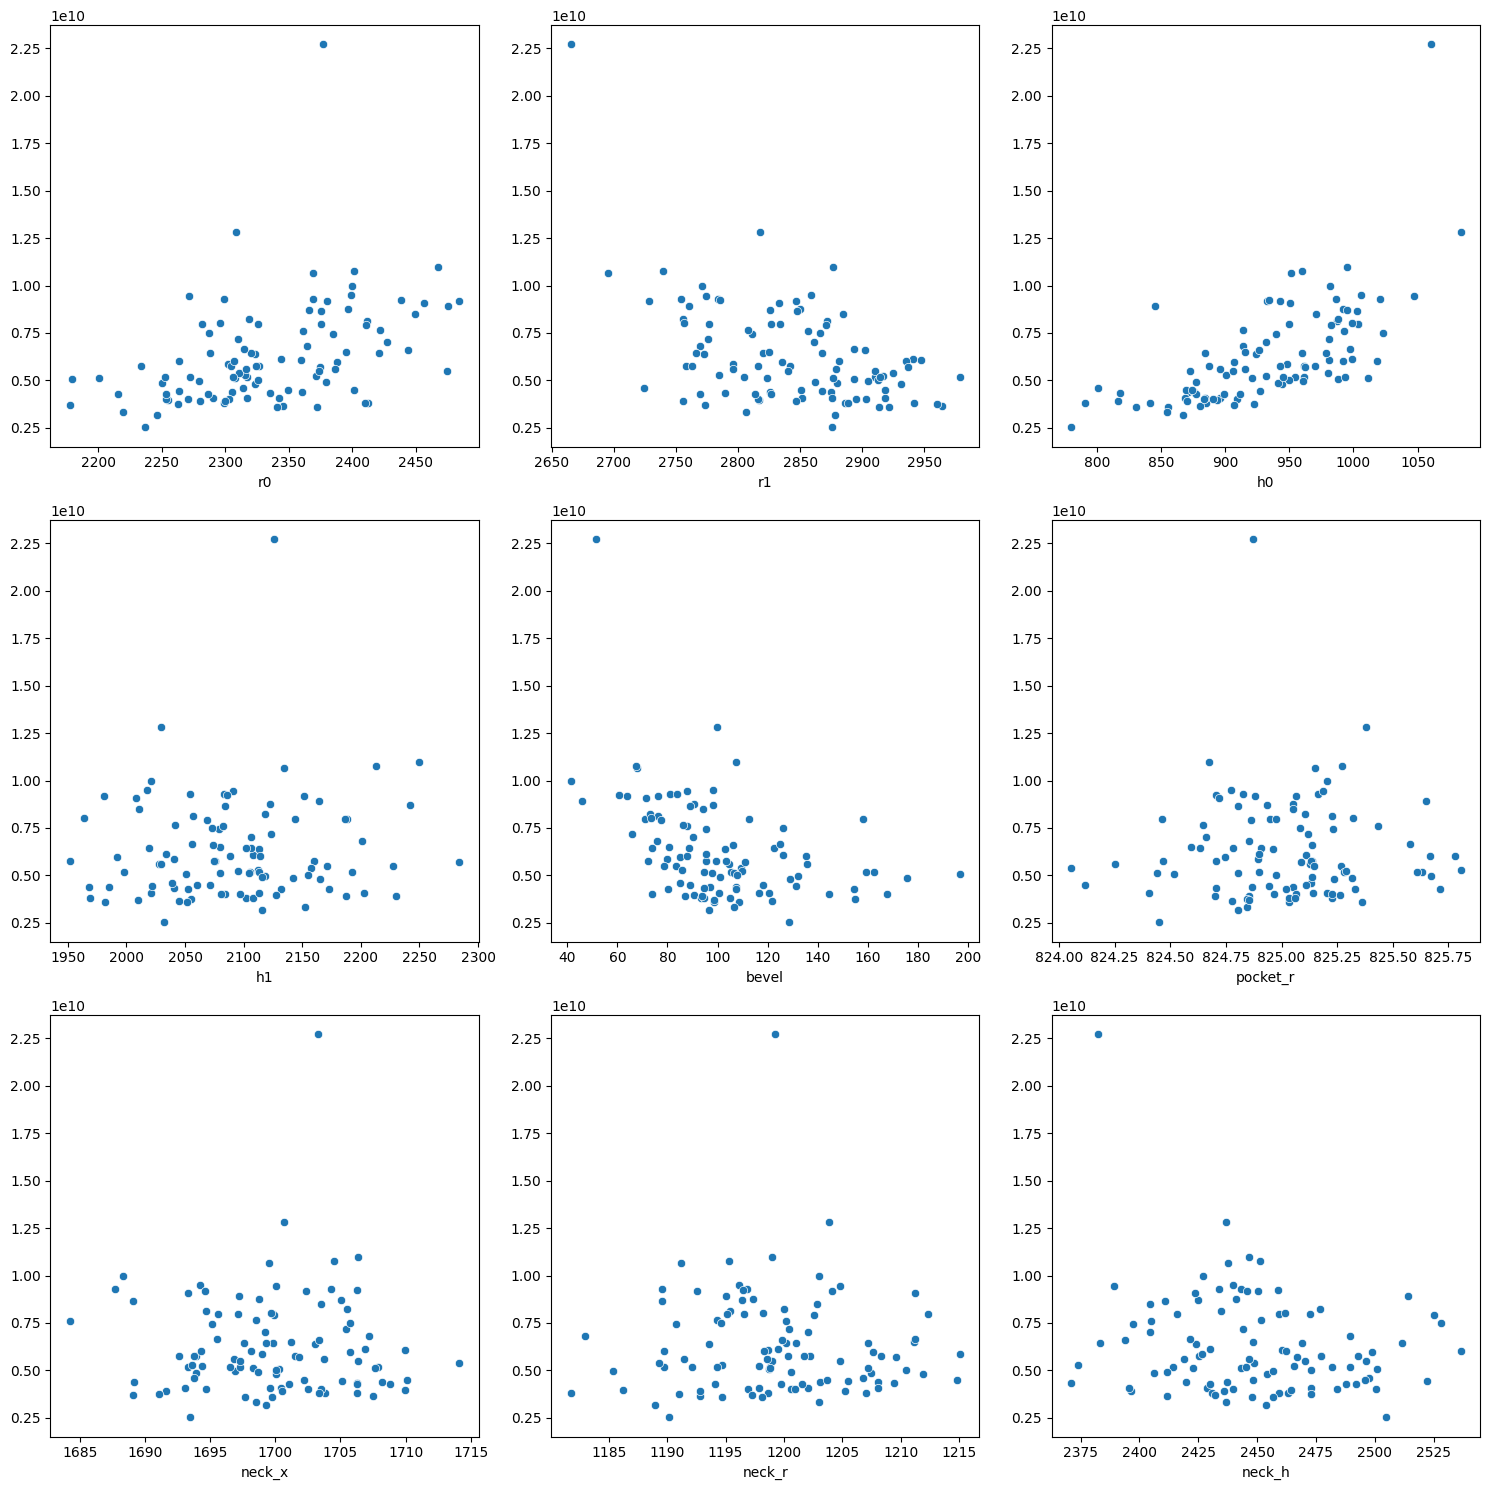

In [5]:
import seaborn as sns

# 3x3のグリッドでプロットを作成
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    x = df.iloc[:,i] * 1e6
    sns.scatterplot(x=x, y=mises_array, ax=ax)

# タイトルと余白の調整
plt.tight_layout()
plt.show()